In [1]:
import sys
import torch
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns


folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnep import CNEP
from cnmp import CNMP

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
def generate_sin(x):
    return torch.sin(x)


num_demos, v_num_demos = 512, 64
num_classes = 8  # Number of modes
num_indiv = num_demos // num_classes  # Number of trajectories per mode
num_val_indiv = v_num_demos // num_classes  # Number of trajectories per mode
t_steps = 200
dy = 1

# x = torch.linspace(0, 1, t_steps).repeat(num_demos, 1).unsqueeze(-1)
# vx = torch.linspace(0, 1, t_steps).repeat(v_num_demos, 1).unsqueeze(-1)
vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(v_num_demos, t_steps, dy)
x = torch.linspace(0, 1, t_steps).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

# Increased range of coefficients for 8 modes
coefficients = torch.linspace(1, 4, num_classes) * torch.pi 

for i in range(num_classes):
    start_ind = i * num_indiv
    coeff = coefficients[i]  # Use coefficient from the list
    phase_shifts = torch.rand(num_indiv) * 8e-2 * torch.pi

    # Expand dimensions for proper broadcasting
    expanded_x = x.expand(num_indiv, -1) + 0.3  # Shape: (64, 200)
    expanded_phase_shifts = phase_shifts.unsqueeze(1).expand(-1, x.shape[1])  # Shape: (64, 200)

    # Generate sinusoids with varying frequencies and random phase shifts
    y[start_ind: start_ind + num_indiv, :, :] = torch.unsqueeze(generate_sin(expanded_x * coeff + expanded_phase_shifts), 2)
    noise = torch.unsqueeze(torch.clamp(torch.randn(vx.shape)*0.01, min=0), -1)
    start_ind = i*num_val_indiv
    vy[start_ind:start_ind+num_val_indiv] = y[start_ind:start_ind+num_val_indiv].clone() + noise

x = x.repeat(num_classes, 1).unsqueeze(-1)
vx = vx.repeat(num_classes, 1).unsqueeze(-1)
# Ensure y values are within [-1, 1]
y = y - y.mean(dim=1, keepdim=True) # Center the means of each trajectory around zero.

print(x.shape, y.shape)
print(vx.shape, vy.shape)

torch.Size([512, 200, 1]) torch.Size([512, 200, 1])
torch.Size([64, 200, 1]) torch.Size([64, 200, 1])


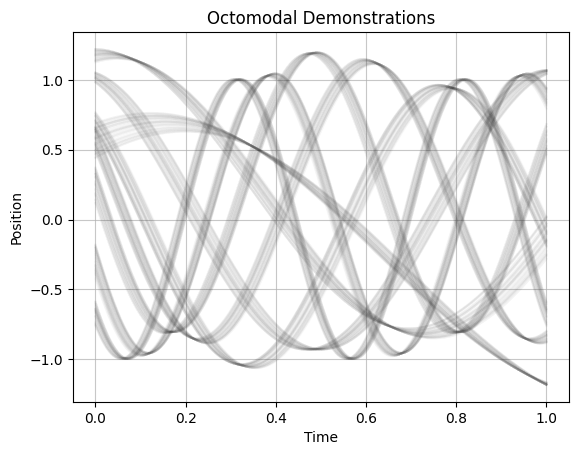

In [3]:
# Create a figure with two subplots sharing the y-axis
# fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# # Plot the first component (y[:,:,0])
# axs[0].plot(x_np[0], y_np[:, :, 0].T)  # Transpose to plot each trajectory separately
# axs[0].set_title('First Component (y[:,:,0])')
# axs[0].set_xlabel('x')
# axs[0].set_ylabel('y')

# # Plot the second component (y[:,:,1])
# axs[1].plot(x_np[0], y_np[:, :, 1].T) 
# axs[1].set_title('Second Component (y[:,:,1])')
# axs[1].set_xlabel('x')

# plt.tight_layout()  # Adjust layout for better spacing
# plt.show()

for i in range(y.shape[0]):  # Iterate over each trajectory
    plt.plot(x[i,:,0], y[i, :, 0], color='#4d4d4d', alpha=0.02)

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Octomodal Demonstrations')
plt.grid(alpha=0.7)

# Show the plot
plt.show()

In [4]:
# Hyperparameters
batch_size = 64
n_max, m_max = 6, 6

t_steps = 200
num_demos = 512
num_classes = 8
num_indiv = num_demos//num_classes  # number of demos per class
dx, dy = 1, 1

num_val = 64
num_val_indiv = num_val//num_classes

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

In [5]:
x, y = x.to(device), y.to(device)
print(x.shape, y.shape)

torch.Size([512, 200, 1]) torch.Size([512, 200, 1])


In [6]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)  # X
        obs[i, :n, dx:] = traj[n_ids]  # Y
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_y[i, :m] = traj[m_ids]
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = (n_ids/t_steps).unsqueeze(1)
        val_obs[i, :n, dx:] = traj[n_ids]
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = (m_ids/t_steps).unsqueeze(1)
        val_tar_y[i] = traj[m_ids]

In [7]:
model2_ = CNEP(1, 1, n_max, n_max, [256,256], num_decoders=2, decoder_hidden_dims=[130, 130], batch_size=batch_size, scale_coefs=True, device=device)
optimizer2 = torch.optim.Adam(lr=3e-4, params=model2_.parameters())

model4_ = CNEP(1, 1, n_max, n_max, [256,256], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
optimizer4 = torch.optim.Adam(lr=3e-4, params=model4_.parameters())

model8_ = CNEP(1, 1, n_max, n_max, [256,256], num_decoders=8, decoder_hidden_dims=[32, 32], batch_size=batch_size, scale_coefs=True, device=device)
optimizer8 = torch.optim.Adam(lr=3e-4, params=model8_.parameters())

cnmp_ = CNMP(1, 1, n_max, m_max, [182,182,182], decoder_hidden_dims=[182,182,182], batch_size=batch_size, device=device)
optimizer_cnmp = torch.optim.Adam(lr=1e-4, params=cnmp_.parameters())

def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("cnep2:", get_parameter_count(model2_))
print("cnep4:", get_parameter_count(model4_))
print("cnep8:", get_parameter_count(model8_))
print("cnmp:", get_parameter_count(cnmp_))

if torch.__version__ >= "2.0":
    model2, model4, model8, cnmp = torch.compile(model2_), torch.compile(model4_), torch.compile(model8_), torch.compile(cnmp_)
else:
    model2, model4, model8, cnmp = model2_, model4_, model8_, cnmp_

cnep2: 134678
cnep4: 134156
cnep8: 135192
cnmp: 134318


In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/ablation/octomodal/2_4_8/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 2_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss2, avg_loss4, avg_loss8, avg_loss_cnmp = 0, 0, 0, 0

val_per_epoch = 1000
min_vl2, min_vl4, min_vl8, min_vl_cnmp = 1000000, 1000000, 1000000, 1000000

mse_loss = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_loss2, epoch_loss4, epoch_loss8, epoch_loss_cnmp = 0, 0, 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(y, traj_ids[i])

        optimizer2.zero_grad()
        pred2, gate2 = model2(obs, tar_x, obs_mask)
        loss2, nll2 = model2.loss(pred2, gate2, tar_y, tar_mask)
        loss2.backward()
        optimizer2.step()


        optimizer4.zero_grad()
        pred4, gate4 = model4(obs, tar_x, obs_mask)
        loss4, nll4 = model4.loss(pred4, gate4, tar_y, tar_mask)
        loss4.backward()
        optimizer4.step()


        optimizer8.zero_grad()
        pred8, gate8 = model8(obs, tar_x, obs_mask)
        loss8, nll8 = model8.loss(pred8, gate8, tar_y, tar_mask)
        loss8.backward()
        optimizer8.step()


        optimizer_cnmp.zero_grad()
        pred = cnmp(obs, tar_x, obs_mask)
        loss = cnmp.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer_cnmp.step()

        epoch_loss2 += nll2.item()
        epoch_loss4 += nll4.item()
        epoch_loss8 += nll8.item()
        epoch_loss_cnmp += loss.item()

    epoch_loss2 = epoch_loss2/epoch_iter
    epoch_loss4 = epoch_loss4/epoch_iter
    epoch_loss8 = epoch_loss8/epoch_iter
    epoch_loss_cnmp = epoch_loss_cnmp/epoch_iter

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss2, val_loss4, val_loss8, val_loss_cnmp = 0, 0, 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vy, v_traj_ids[j])

                p_wta, g_wta = model2.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss2 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model4.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss4 += mse_loss(vp_means, val_tar_y).item()

                p_wta, g_wta = model8.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss8 += mse_loss(vp_means, val_tar_y).item()

                p = cnmp.val(val_obs, val_tar_x, val_obs_mask)
                vp_means = p[:, :, :dy]
                val_loss_cnmp += mse_loss(vp_means, val_tar_y).item()

            if val_loss2 < min_vl2:
                min_vl2 = val_loss2
                print(f'New best 2: {min_vl2}')
                torch.save(model2_.state_dict(), f'{root_folder}saved_models/cnep2.pt')

            if val_loss4 < min_vl4:
                min_vl4 = val_loss4
                print(f'New best 4: {min_vl4}')
                torch.save(model4_.state_dict(), f'{root_folder}saved_models/cnep4.pt')

            if val_loss8 < min_vl8:
                min_vl8 = val_loss8
                print(f'New best 8: {min_vl8}')
                torch.save(model8_.state_dict(), f'{root_folder}saved_models/cnep8.pt')

            if val_loss_cnmp < min_vl_cnmp:
                min_vl_cnmp = val_loss_cnmp
                print(f'CNMP New best: {min_vl_cnmp}')
                torch.save(cnmp_.state_dict(), f'{root_folder}saved_models/cnmp.pt')
            
            print(f'Bests: {min_vl2}, {min_vl4}, {min_vl8}, {min_vl_cnmp}')

    avg_loss2 += epoch_loss2
    avg_loss4 += epoch_loss4
    avg_loss8 += epoch_loss8
    avg_loss_cnmp += epoch_loss_cnmp

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, Losses: {}, {}, {}, {}".format(epoch, avg_loss2/val_per_epoch, avg_loss4/val_per_epoch, avg_loss8/val_per_epoch, avg_loss_cnmp/val_per_epoch))
        avg_loss2, avg_loss4, avg_loss8, avg_loss_cnmp = 0, 0, 0, 0

New best 2: 0.49605605006217957
New best 4: 0.5066022276878357
New best 8: 0.49844884872436523
CNMP New best: 0.5008217692375183
Bests: 0.49605605006217957, 0.5066022276878357, 0.49844884872436523, 0.5008217692375183
Epoch: 0, Losses: 0.0005226050391793251, 0.00026129249110817907, 0.0001312914937734604, 0.0010440043956041335
New best 2: 0.27065354585647583
New best 4: 0.2654893100261688
New best 8: 0.2569834589958191
CNMP New best: 0.3630959689617157
Bests: 0.27065354585647583, 0.2654893100261688, 0.2569834589958191, 0.3630959689617157
Epoch: 1000, Losses: 0.46196424374356865, 0.2587207537330687, 0.12637504469044505, 0.7969092100039125
Bests: 0.27065354585647583, 0.2654893100261688, 0.2569834589958191, 0.3630959689617157
Epoch: 2000, Losses: 0.39289442766830324, 0.22233233805559577, 0.10997964344453066, 0.5025805048604961
Bests: 0.27065354585647583, 0.2654893100261688, 0.2569834589958191, 0.3630959689617157
Epoch: 3000, Losses: 0.3397531981766224, 0.20188369673956186, 0.105097805464640